# <center> Analyse de la concentration de CO2, <center>

In [92]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interpolate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"    
# ‘all’|’last’|’last_expr’|’none’
#https://jupyter-console.readthedocs.io/en/4.0.1/config_options.html

Nous récupérons les données les plus récentes sur le site en pointant sur un fichier au format .csv, si cette récupération est possible nous enregistrons une copie de ce fichier. Si pour une raison quelconque nous n'arrivons pas a faire ce téléchargement, nous travaillons sur le dernières données téléchargé.

In [93]:
try:
    raw_data = pd.read_csv("https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/"
                           "in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv",skiprows=56)
except OSError as err:
    print("Erreur lors du téléchargement : {0}".format(err))
    print("Nous téléchargeons les dernières données enregistrer sur notre PC")
    raw_data = pd.read_csv("monthly_in_situ_co2_mlo")
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise
else:
    raw_data.to_csv('monthly_in_situ_co2_mlo',index=True)

raw_data.head(5)

Excel                 [ppm]      [ppm]         [ppm]  \
0  1958    1     21200   1958.0411    -99.99      -99.99       -99.99   
1  1958    2     21231   1958.1260    -99.99      -99.99       -99.99   
2  1958    3     21259   1958.2027    315.70      314.44       316.19   
3  1958    4     21290   1958.2877    317.45      315.16       317.30   
4  1958    5     21320   1958.3699    317.51      314.71       317.86   

       [ppm]         [ppm]      [ppm].1  
0     -99.99        -99.99       -99.99  
1     -99.99        -99.99       -99.99  
2     314.91        315.70       314.44  
3     314.99        317.45       315.16  
4     315.06        317.51       314.71

Nous voyons que les noms des colonnes ne sont pas très représentatives, nous modifions  les noms des colonnes

In [94]:
raw_data_1 = raw_data.copy()
print(raw_data.columns)
raw_data_1.columns = ['Yr','Mn','Date 1','Date 2','s1','s2','s3','s4','s5','s6']

Index(['    ', '   ', '   Excel', '          ', '   [ppm]', '    [ppm] ',
       '      [ppm]', '    [ppm]', '       [ppm]', '    [ppm].1'],
      dtype='object')


In [95]:
raw_data_1.head()

Yr  Mn  Date 1     Date 2      s1      s2      s3      s4      s5      s6
0  1958   1   21200  1958.0411  -99.99  -99.99  -99.99  -99.99  -99.99  -99.99
1  1958   2   21231  1958.1260  -99.99  -99.99  -99.99  -99.99  -99.99  -99.99
2  1958   3   21259  1958.2027  315.70  314.44  316.19  314.91  315.70  314.44
3  1958   4   21290  1958.2877  317.45  315.16  317.30  314.99  317.45  315.16
4  1958   5   21320  1958.3699  317.51  314.71  317.86  315.06  317.51  314.71

Les données vide sont représentés par la valeur -99.99, nous remplaçons cette valeur par une valeur plus adéquate NaN dans une autre DataFrame

In [96]:
date = datetime.date.today()
data = raw_data_1.copy()
data = data.drop(data[(data.Yr == date.year) & (data.Mn > date.month)].index)
data = data.replace(-99.99,np.NaN);
d = data[(data.Yr == date.year)].index
i,k = d[0], d[-1]

while k>=i:
    if data.loc[k].isnull().any():
        data = data.drop(k)
    else:
        break
    k = k - 1
    
annee, mois  = data.Yr[0], data.Mn[0]
d = data[(data.Yr == annee)].index
i,k = d[0], d[-1]

while i<=k:
    if data.loc[i].isnull().any():
        data = data.drop(i)
    else:
        break
    i = i + 1
InteractiveShell.ast_node_interactivity = "all"     
data.head(3)
data.tail(3)
InteractiveShell.ast_node_interactivity = "last_expr"  

On visualise les lignes dont une donnée colonne est manquante.

In [97]:
data[data.isnull().any(axis=1)]

Yr  Mn  Date 1     Date 2  s1  s2      s3      s4      s5      s6
5   1958   6   21351  1958.4548 NaN NaN  317.24  315.14  317.24  315.14
9   1958  10   21473  1958.7890 NaN NaN  312.44  315.40  312.44  315.40
73  1964   2   23422  1964.1257 NaN NaN  320.01  319.36  320.01  319.36
74  1964   3   23451  1964.2049 NaN NaN  320.74  319.41  320.74  319.41
75  1964   4   23482  1964.2896 NaN NaN  321.83  319.45  321.83  319.45

In [98]:
data.head()

Yr  Mn  Date 1     Date 2      s1      s2      s3      s4      s5      s6
2  1958   3   21259  1958.2027  315.70  314.44  316.19  314.91  315.70  314.44
3  1958   4   21290  1958.2877  317.45  315.16  317.30  314.99  317.45  315.16
4  1958   5   21320  1958.3699  317.51  314.71  317.86  315.06  317.51  314.71
5  1958   6   21351  1958.4548     NaN     NaN  317.24  315.14  317.24  315.14
6  1958   7   21381  1958.5370  315.86  315.19  315.86  315.22  315.86  315.19

On ajoute un index ' périod' à la DataFrame, cet index représente la période de mesure. 
Cette date est mise dans au format compréhensible par pandas. On visualise toutes les lignes qui seront supprimées.

In [99]:
data['period'] = pd.Series([datetime.date(y,m,1) for y,m in zip(data['Yr'],data['Mn'])])
data1 = data.dropna().copy()
data1 = data1.set_index('period')   
data1.head()

Yr  Mn  Date 1     Date 2      s1      s2      s3      s4  \
period                                                                    
1958-05-01  1958   3   21259  1958.2027  315.70  314.44  316.19  314.91   
1958-06-01  1958   4   21290  1958.2877  317.45  315.16  317.30  314.99   
1958-07-01  1958   5   21320  1958.3699  317.51  314.71  317.86  315.06   
1958-09-01  1958   7   21381  1958.5370  315.86  315.19  315.86  315.22   
1958-10-01  1958   8   21412  1958.6219  314.93  316.19  314.00  315.29   

                s5      s6  
period                      
1958-05-01  315.70  314.44  
1958-06-01  317.45  315.16  
1958-07-01  317.51  314.71  
1958-09-01  315.86  315.19  
1958-10-01  314.93  316.19

Représentation graphique de la concentration  de CO2 de 1958 à nos jours

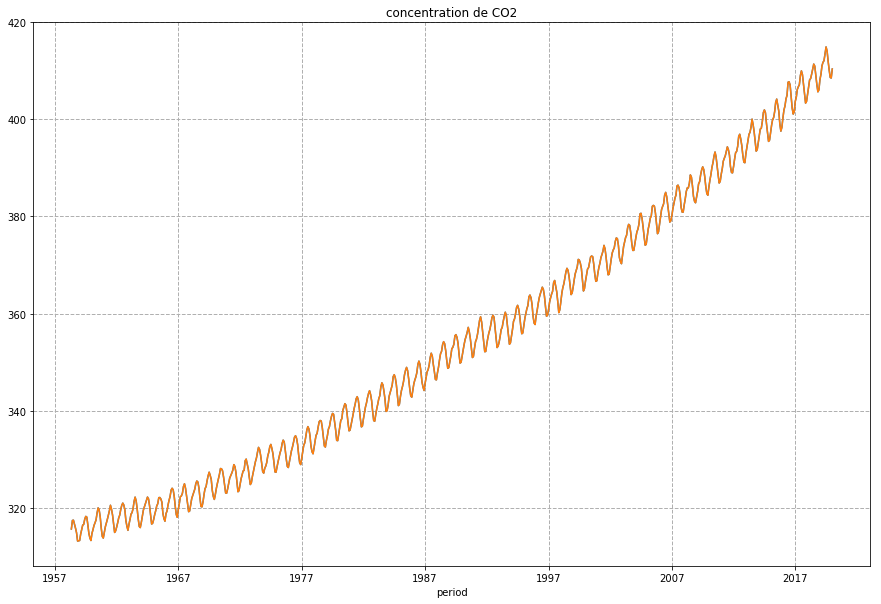

In [100]:
data1['s1'].plot(title = 'concentration de CO2',);
data1['s1'].plot(figsize=(15, 10),).grid(linestyle='--', linewidth=1);

Nous allons approximé la concentration de CO2 avec une droite, puis faire la différence pour 
n'obtenir que les variations de la concentration de CO2.

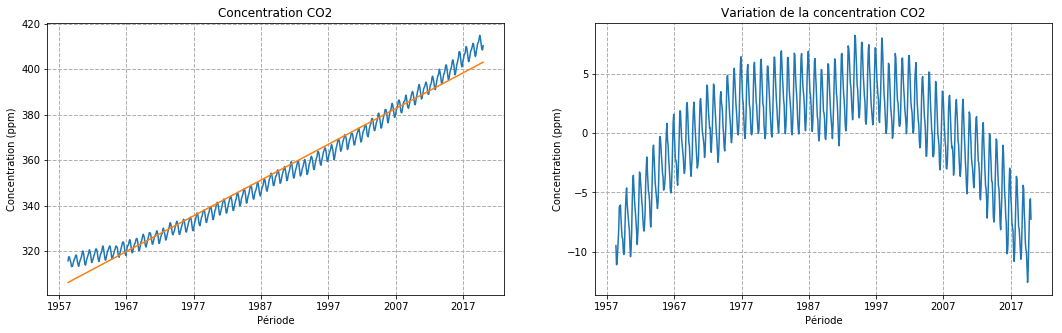

In [101]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(data1['Date 2'], data1['s1'])
def predict(x):
    return slope*x+intercept

data_lineaire = data1.copy()
data_lineaire['reg_lineaire'] = predict(data_lineaire['Date 2'])

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)
#plot(figsize=(8, 5))  .plot(figsize=(15, 10), grid=True).grid(linestyle='--', linewidth=1);

ax1.set(title = 'Concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax1.plot(data_lineaire['s1'])
#data1['s1'].plot()
ax1.plot(data_lineaire['reg_lineaire']) 
data_lineaire['co2'] = data_lineaire['reg_lineaire']-data_lineaire['s1']
ax2.set(title = 'Variation de la concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax2.plot(data_lineaire['co2']); 

Le résultat n'est pas satisfaisant ...
Nous pouvons faire une optimisation avec une fonction de la forme $a*(x-b)^2+c$

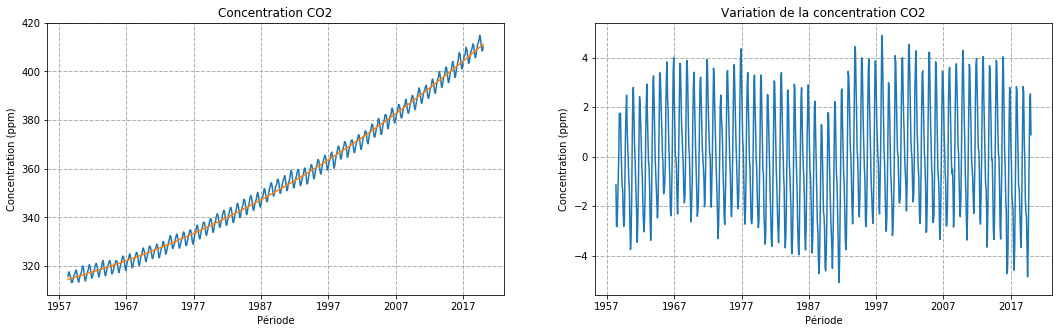

In [102]:
from scipy.optimize import curve_fit

def func(x,a,b,c):
    return a*(x-b)**(2)+c

data_cube = data1.copy()

x = data_cube['Date 2']
y = data_cube['s1']
popt, pcov = curve_fit(func,x,y)

def fa(x):
    return popt[0]*(x- popt[1])**(2)+popt[2]

data_cube['reg_cube'] = fa(data_cube['Date 2'])

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)

ax1.set(title = 'Concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax1.plot(data_cube['s1'])
ax1.plot(data_cube['reg_cube']) 
data_cube['co2'] = data_cube['reg_cube']-data_cube['s1']
ax2.set(title = 'Variation de la concentration CO2',xlabel='Période',ylabel='Concentration (ppm)')
ax2.plot(data_cube['co2']); 

Nous recherchons l'oscillation lente, pour cela nous allons opéré en 2 etapes :
- Recherche de la fréquence lente, par FFT. Pour cela nous devons faire une interpolation pour les quelque points manquant. Ce qui nous donnera une gamme de fréquence possible (échantillonne de la FFT)
- Pour la gamme de fréquence spécifiées, nous  estimons tous les paramètres pour une approximation sinusoïdale (moyenne, amplitude et phase) par les moindres carrés ordinaires 


In [103]:
data['period'] = pd.Series([datetime.date(y,m,1) for y,m in zip(data['Yr'],data['Mn'])])
data = data.set_index('period')   
data.head()
data[data.isnull().any(axis=1)]

Yr  Mn  Date 1     Date 2  s1  s2      s3      s4      s5  \
period                                                                    
1958-08-01  1958   6   21351  1958.4548 NaN NaN  317.24  315.14  317.24   
1958-12-01  1958  10   21473  1958.7890 NaN NaN  312.44  315.40  312.44   
1964-04-01  1964   2   23422  1964.1257 NaN NaN  320.01  319.36  320.01   
1964-05-01  1964   3   23451  1964.2049 NaN NaN  320.74  319.41  320.74   
1964-06-01  1964   4   23482  1964.2896 NaN NaN  321.83  319.45  321.83   

                s6  
period              
1958-08-01  315.14  
1958-12-01  315.40  
1964-04-01  319.36  
1964-05-01  319.41  
1964-06-01  319.45